# Micromagnetic standard problem 4

**Author**: Marijan Beg

**Date**: 4 May 2016

## Problem specification

The simulated sample is a thin film cuboid with dimensions:
- length $Lx = 500 \,\text{nm}$,
- width $Ly = 125 \,\text{nm}$, and
- thickness $t = 3 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = -\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff}) + \alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ is the gyromagnetic ratio and $\alpha=0.02$ is the Gilbert damping.

In the standard problem 4, the system is firstly relaxed at zero external magnetic field and then, stating from the obtained equlibrium configuration, the magnetisation dynamics is simulated for each of two different external magnetic fields:

1. $\mathbf{H}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$
2. $\mathbf{H}_{2} = (-35.5, -6.3, 0.0) \,\text{mT}$

The micromagnetic standard problem 4 specification can be also found in Ref. 1.

In [1]:
!make clean

rm -f *.mif
rm -f *.omf


In [2]:
import numpy as np

Lx = 500e-9  # x dimension of the sample(m)
Ly = 125e-9  # y dimension of the sample (m)
thickness = 3e-9  # sample thickness (m)
dx = dy = 5e-9 # discretisation in x and y directions (m)
dz = 3e-9  # discretisation in the z direction (m)

# Minimum sample coordinate.
cmin = (0, 0, 0)
# Maximum sample coordinate.
cmax = (Lx, Ly, thickness)
# Discretisation.
d = (dx, dy, dz)

mu0 = 4*np.pi*1e-7  # magnetic constant (H/m)

Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)

## First stage

In the first stage, we relax the system at zero external magnetic field. Firstly, required modules are imported.

In [3]:
import sys

sys.path.append('../')

from sim import Sim
from atlases import BoxAtlas
from meshes import RectangularMesh
from energies.exchange import UniformExchange
from energies.demag import Demag
from energies.zeeman import FixedZeeman

Now, atlas, mesh, and simulation objects are created.

In [4]:
atlas = BoxAtlas(cmin, cmax)
mesh = RectangularMesh(atlas, d)
sim = Sim(mesh, Ms, name='first_stage')

Energy terms (exchange and demagnetisation) are added to the system's Hamiltonian.

In [5]:
# Add exchange energy.
sim.add(UniformExchange(A))

# Add demagnetisation energy.
sim.add(Demag())

System is initialised so that the magnetisation at all mesh cells is $(1, 0.25, 0.1)$.

In [6]:
sim.set_m((1, 0.25, 0.1))  # initialise the magnetisation

At this point, system can be relaxed. We relax the system by simulating the magnetisation time evolution for $5 \,\text{ns}$ with default value of Gilbert damping $\alpha = 1$.

In [7]:
sim.relax(stopping_mxHxm=0.0001)  # run time evolution for 5 ns with default value of Gilbert damping (alpha=1)

# MinDriver
Specify Oxs_MinDriver {
	evolver evolver
	stopping_mxHxm 0.0001
	mesh :mesh
	Ms 800000.0
	m0 {
		Oxs_UniformVectorField {
			vector { 1 0.25 0.1 }
		}
	}
	basename first_stage
	vector_field_output_format {text %\#.8g}
}




The relaxed state is now saved into the omf file, which we can load into the Field object:

In [9]:
!ls
from field import Field, load_oommf_file

m0 = load_oommf_file('first_stage-Oxs_MinDriver-Spin-00-0000368.omf')

first_stage.mif				       Makefile
first_stage-Oxs_MinDriver-Spin-00-0000368.omf  standard_problem4.ipynb
fmr_standard_problem.ipynb		       stdprob4relax.ipynb


Using the field object, we can compute the magnetisation average, sample the magnetisation at the point, or plot the magnetisation slice of the sample.

The average magnetisation is [0.96720772601360883, 0.12482105078076225, -3.7669927915088464e-13]
The magnetisation at point (5e-08, 7.5e-08, 1e-09) is [  9.63258329e-01   2.68576602e-01  -3.45248438e-12]


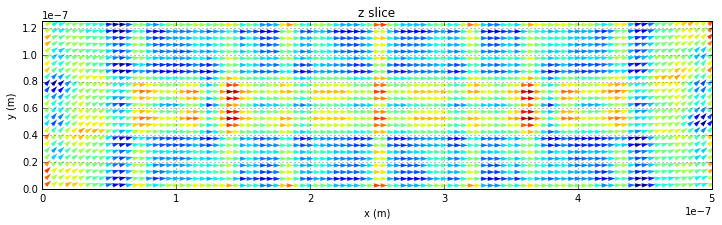

In [10]:
# Compute the average magnetisation.
print 'The average magnetisation is', m0.average()

# Sample the magnetisation at the point.
c = (50e-9, 75e-9, 1e-9)
print 'The magnetisation at point {} is {}'.format(c, m0(c))

# Plot the slice.
%matplotlib inline
m0.plot_slice('z', 1e-9)

## Second stage

In the second stage, the relaxed state from the first stage is used as an initial state. Now, the external magnetic field is applied $\mathbf{H}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$.

In [11]:
sim = Sim(mesh, Ms, name='second_stage')

# Add exchange energy.
sim.add(UniformExchange(A))

# Add demagnetisation energy.
sim.add(Demag())

# Add Zeeman energy.
H = np.array([-24.6, 4.3, 0.0])*1e-3 / mu0  # external magnetic field in the first stage
sim.add(FixedZeeman(H))

The magnetisation can be initialised using a Field object.

In [12]:
sim.set_m(m0)

In this stage, we use a smaller value of Gilbert damping in comparison to the first stage, where default value (alpha=1) was used.

In [13]:
sim.alpha = 0.02

Now, we can run the simulation for $1 \,\text{ns}$ and save the magnetisation field at 500 time steps.

In [14]:
dt = 2e-12
n_steps = 500

sim.run_multiple_stages(dt, n_steps)

## Postprocessing

The results should be a time dependence of magnetisation $y$ component average.

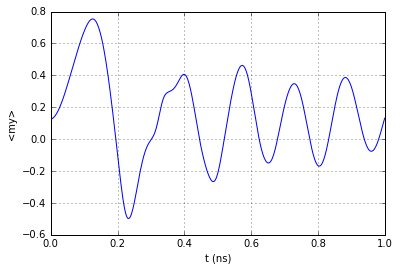

In [15]:
import glob
import matplotlib.pyplot as plt

# Compute the <my> at all recorded time steps. 
t_list = []
myav = []
for i in range(n_steps):
    omf_filename = glob.glob('second_stage-Oxs_TimeDriver-Spin-%07d-*.omf' % i)[0]
    m_field = load_oommf_file(omf_filename)
    t_list.append(i*dt)
    myav.append(m_field.average()[1])
    
t_array = np.array(t_list)
myav = np.array(myav)

# Plot the <my> time evolution.
plt.plot(t_array/1e-9, myav)
plt.xlabel('t (ns)')
plt.ylabel('<my>')
plt.grid()

### References
[1] http://www.ctcms.nist.gov/~rdm/mumag.org.html